In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('C://Users//demey//Documents//2024-2025//Industry Project//Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')

In [20]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics','cholecystectomy_repair','hiatus_hernia_repair','drain']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())

Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']
Remaining columns in CM data: ['CM_AIDS', 'CM_ANEMDEF', 'CM_ARTH', 'CM_CHF', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_OBESE', 'CM_PSYCH', 'CM_SMOKE', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD']


In [21]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [22]:
core_Y_data=df_new[["complication"]]

core_Y_data.head()

,complication
0,0
1,0
2,1
3,0
4,0


In [23]:
core_X_data.replace(to_replace="Female", value=1, inplace=True)
core_X_data.replace(to_replace="Male", value=0,inplace=True)

In [24]:
core_X_data
def one_hot_encode(dataset:pd.DataFrame, column:str, prefixset:str)->pd.DataFrame:
    dataset=pd.concat([dataset, pd.get_dummies(dataset[column], prefix=prefixset, dtype=int)], axis=1)
    dataset.drop(column, axis=1, inplace=True)
    return dataset

core_X_data = one_hot_encode(core_X_data, 'procedure_category', 'proc')
core_X_data = one_hot_encode(core_X_data, 'antibiotics', 'ab')
core_X_data = one_hot_encode(core_X_data, 'cholecystectomy_repair', 'chole')

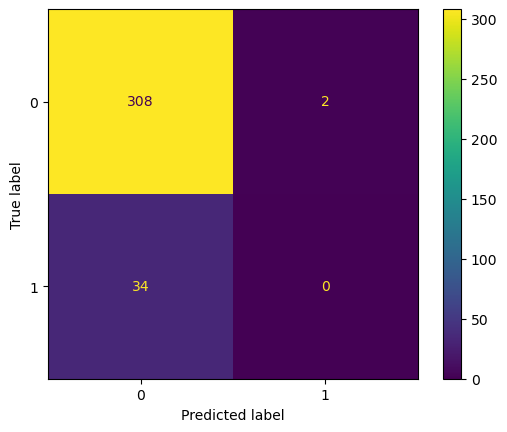

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use this instead of RandomForestRegressor if you're classifying
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# Generate predictions
y_pred = cross_val_predict(model, X, y, cv=5)

# Confusion matrix
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()



In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'randomforestclassifier__n_estimators': randint(100, 1000),
    'randomforestclassifier__max_depth': [None] + list(range(5, 31, 5)),
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

print("Best params:", search.best_params_)
print("Best cross-val accuracy:", search.best_score_)


Best params: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 171}
Best cross-val accuracy: 0.9011935208866155


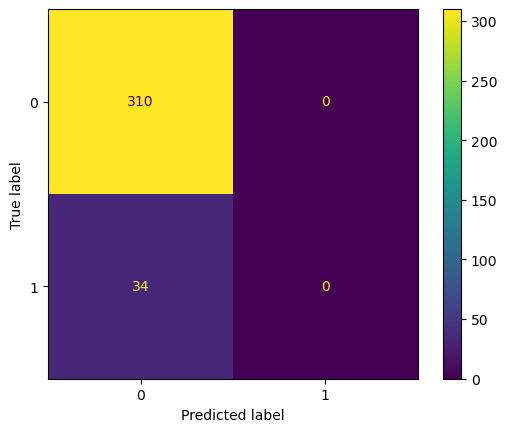

In [28]:
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=171,
        max_depth=30,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=10,
        random_state=42
    )
)

y_pred = cross_val_predict(model, X, y, cv=5)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [29]:
model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=171,
        max_depth=30,
        max_features='sqrt',
        min_samples_leaf=4,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    )
)


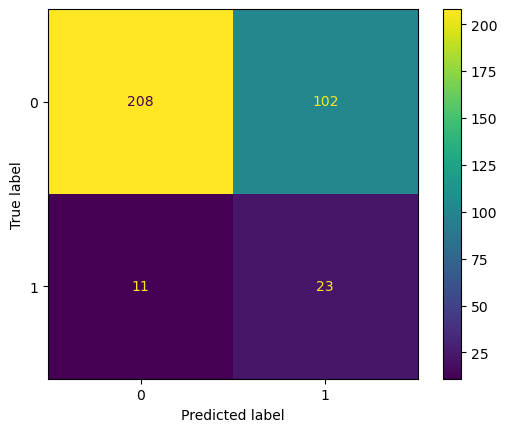

In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Apply custom threshold
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred_thresh)
ConfusionMatrixDisplay(cm).plot()
plt.show()


Best threshold for F1: 0.38
Precision: 0.22, Recall: 0.56, F1: 0.32


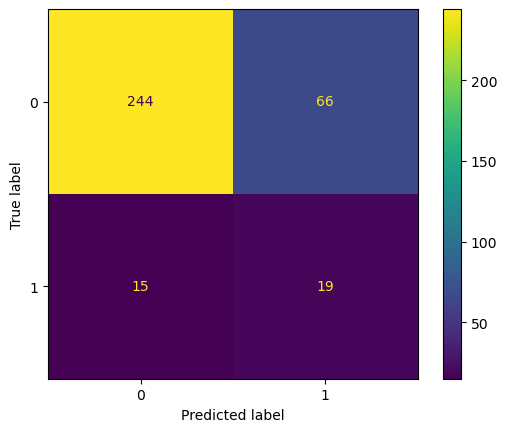

In [31]:
from sklearn.metrics import precision_recall_curve, f1_score

# Get probabilities as before
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Precision-recall threshold sweep
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Compute F1 score at each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = f1s.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold for F1: {best_threshold:.2f}")
print(f"Precision: {precisions[best_idx]:.2f}, Recall: {recalls[best_idx]:.2f}, F1: {f1s[best_idx]:.2f}")

# Apply best threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y, y_pred_opt)
ConfusionMatrixDisplay(cm).plot()
plt.show()


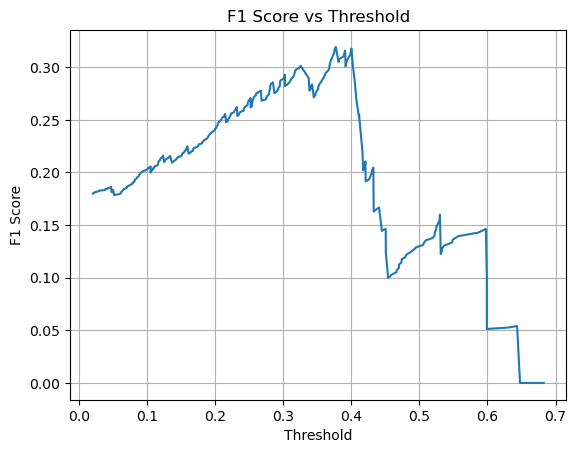

In [32]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1s[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics import precision_recall_curve, f1_score

# Probabilities from cross-validated model
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Trim so thresholds match
thresholds = np.append(thresholds, 1.0)  # to match length of precisions/recalls

# Print threshold sweep for class 1
for t, p, r in zip(thresholds, precisions, recalls):
    if r >= 0.6 and p >= 0.3:  # adjust these as your desired minimums
        print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {2*p*r/(p+r + 1e-8):.2f}")


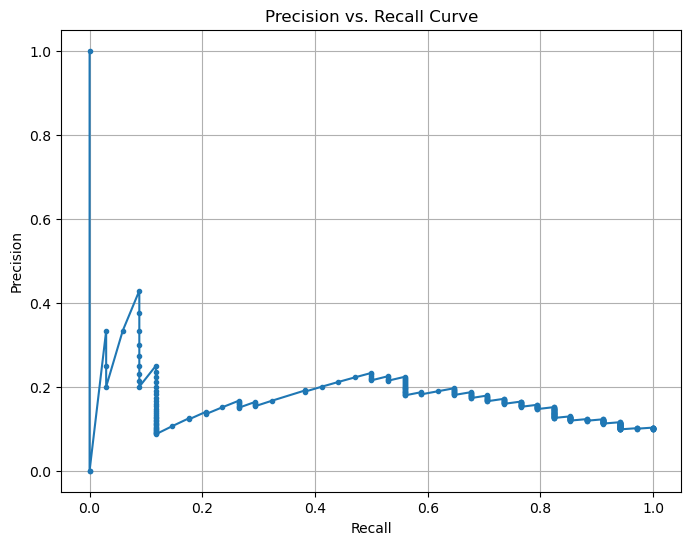

In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities (already done earlier)
y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Compute precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall Curve')
plt.grid(True)
plt.show()


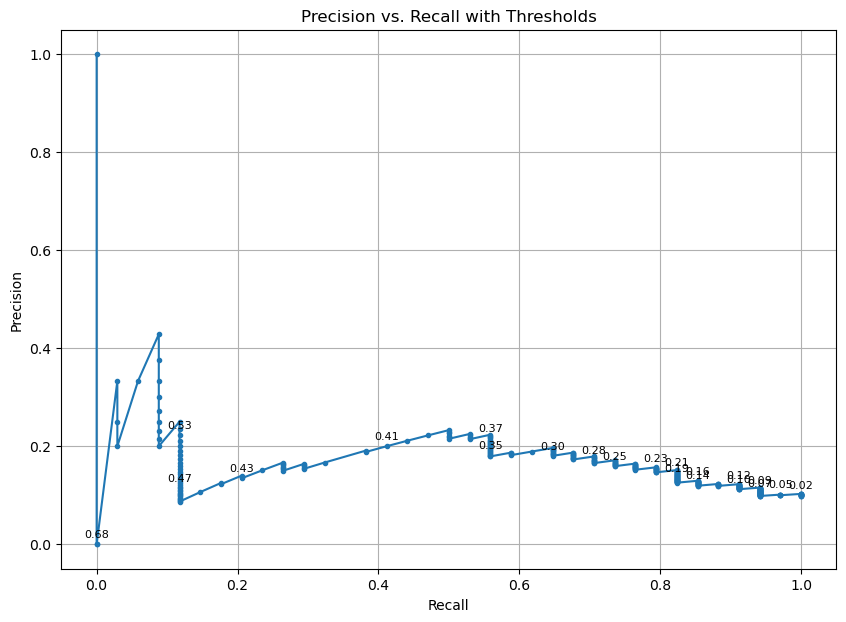

In [36]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_proba)

# Trim to match length for plotting points
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall with Thresholds')
plt.grid(True)

# Annotate thresholds
for i in range(0, len(thresholds), max(1, len(thresholds) // 20)):
    plt.annotate(f'{thresholds[i]:.2f}', 
                 (recalls[i], precisions[i]),
                 textcoords="offset points",
                 xytext=(0,5),
                 ha='center',
                 fontsize=8)

plt.show()


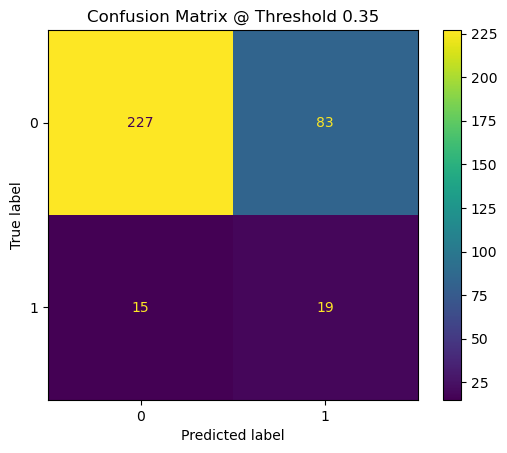

In [40]:
threshold = 0.35  # or try 0.35 / 0.43 based on what you saw

y_pred = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f'Confusion Matrix @ Threshold {threshold}')
plt.show()


In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

accuracy = accuracy_score(y, y_pred)
print(f"Accuracy at threshold {threshold}: {accuracy:.2f}")


recall = recall_score(y, y_pred, pos_label=1)
print(f"Recall (class 1) at threshold {threshold}: {recall:.2f}")

precision = precision_score(y, y_pred, pos_label=1)
print(f"Precision (class 1) at threshold {threshold}: {precision:.2f}")



Accuracy at threshold 0.35: 0.72
Recall (class 1) at threshold 0.35: 0.56
Precision (class 1) at threshold 0.35: 0.19
